In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cwd = Path.cwd()
file_path = cwd.parent / 'data' / 'malicious_phish.csv'
df = pd.read_csv(file_path)
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [3]:
df2 = pd.read_csv(cwd.parent /'data/urlset.csv', on_bad_lines='skip', low_memory=False)
df2

,domain,ranking,mld_res,mld.ps_res,card_rem,ratio_Rrem,ratio_Arem,jaccard_RR,jaccard_RA,jaccard_AR,jaccard_AA,jaccard_ARrd,jaccard_ARrem,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,10000000,1.0,0.0,18.0,107.611111,107.277778,0.000000,0.000000,0.000000,0.000000,0.8,0.795729,1.0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,10000000,0.0,0.0,11.0,150.636364,152.272727,0.000000,0.000000,0.000000,0.000000,0,0.768577,1.0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,10000000,0.0,0.0,14.0,73.500000,72.642857,0.000000,0.000000,0.000000,0.000000,0,0.726582,1.0
3,mail.printakid.com/www.online.americanexpress....,10000000,0.0,0.0,6.0,562.000000,590.666667,0.000000,0.000000,0.000000,0.000000,0,0.85964,1.0
4,thewhiskeydregs.com/wp-content/themes/widescre...,10000000,0.0,0.0,8.0,29.000000,24.125000,0.000000,0.000000,0.000000,0.000000,0,0.748971,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96048,xbox360.ign.com/objects/850/850402.html,339,1.0,1.0,2.0,142.500000,141.000000,0.009009,0.009091,0.006536,0.006601,0.45098,0.846906,0.0
96049,games.teamxbox.com/xbox-360/1860/Dead-Space/,63029,1.0,0.0,3.0,114.000000,128.333333,0.002899,0.002577,0.002907,0.002584,0.75,0.714623,0.0
96050,www.gamespot.com/xbox360/action/deadspace/,753,1.0,1.0,3.0,91.000000,101.333333,0.000000,0.003106,0.000000,0.000000,0.111111,0.648571,0.0
96051,en.wikipedia.org/wiki/Dead_Space_(video_game),6,1.0,1.0,4.0,682.000000,744.250000,0.033075,0.029412,0.030250,0.029145,0.809735,0.840323,0.0


In [4]:

df2 = df2[['domain', 'label']]
df_merge = df.merge(df2, how = 'left', left_on = 'url', right_on = 'domain')

df_merge.loc[df_merge['label']==0, 'type'] = 'benign'
df_merge.loc[df_merge['label']==1, 'type'] = 'phishing'
df = df_merge[['url', 'type']]

df = df.drop_duplicates()
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [5]:
df['type'].describe()

count     641119
unique         4
top       benign
freq      428183
Name: type, dtype: object

In [6]:
df.loc[~(df['type'] == 'benign'),'type'] =1
df.loc[(df['type'] == 'benign'),'type'] =0
df.head()

,url,type
0,br-icloud.com.br,1
1,mp3raid.com/music/krizz_kaliko.html,0
2,bopsecrets.org/rexroth/cr/1.htm,0
3,http://www.garage-pirenne.be/index.php?option=...,1
4,http://adventure-nicaragua.net/index.php?optio...,1


In [7]:
cwd = Path.cwd()
file_path = cwd.parent / 'data' / 'clean_data.csv'
df.to_csv(file_path)

In [8]:
def alphabet_ratio(url):
    url_length = len(url)
    alphabet_count = len(re.findall('[A-Za-z]',url))
    ratio = alphabet_count/ url_length
    return ratio

def digit_ratio(url):
    url_length = len(url)
    digit_count = len(re.findall('[\\d+]',url))
    ratio = digit_count/ url_length
    return ratio

def non_alphanumeric_ratio(url):
    url_length = len(url)
    non_alphanumeric_count = len(re.findall('[^a-zA-Z0-9]', url))
    ratio = non_alphanumeric_count/ url_length
    return ratio

def dot_count(url):
    return len(re.findall('[.]', url))

def dash_count(url):
    return len(re.findall('[-]', url))

def underscore_count(url):
    return len(re.findall('[_]', url))

def slash_count(url):
    return len(re.findall('[/]', url))

def q_mark_count(url):
    return len(re.findall('[?]', url))

def percentage_count(url):
    return len(re.findall('[%]', url))

def http (url):
    return int(len(re.findall('(http)[^s]', url)) > 0)

def https (url):
    return int(len(re.findall('https', url)) > 0)

def php (url):
    return int(len(re.findall('php', url)) > 0)

def html (url):
    return int(len(re.findall('html', url)) > 0)

def feature_extraction(df, col):
    df_copy = df.copy()
    df_copy['length'] = df[col].apply(len)
    df_copy['alphabet_ratio'] = df[col].apply(alphabet_ratio)
    df_copy['digit_ratio'] = df[col].apply(digit_ratio)
    df_copy['non_alphanumeric_ratio'] = df[col].apply(non_alphanumeric_ratio)
    df_copy['dot_count'] = df[col].apply(dot_count)
    df_copy['underscore_count'] = df[col].apply(underscore_count)
    df_copy['slash_count'] = df[col].apply(slash_count)
    df_copy['q_mark_count'] = df[col].apply(q_mark_count)
    df_copy['percentage_count'] = df[col].apply(percentage_count)
    df_copy['http'] = df[col].apply(http)
    df_copy['https'] = df[col].apply(https)
    df_copy['html'] = df[col].apply(html)
    df_copy['php'] = df[col].apply(php)
   

    return df_copy
    

    
df_extracted = feature_extraction(df,'url')


In [9]:
final_df = df_extracted[['length', 'alphabet_ratio', 'digit_ratio',
       'non_alphanumeric_ratio', 'dot_count', 'underscore_count',
       'slash_count', 'q_mark_count', 'percentage_count', 'http', 'https',
       'html', 'php','type']]

final_df.head()

,length,alphabet_ratio,digit_ratio,non_alphanumeric_ratio,dot_count,underscore_count,slash_count,q_mark_count,percentage_count,http,https,html,php,type
0,16,0.812500,0.000000,0.187500,2,0,0,0,0,0,0,0,0,1
1,35,0.828571,0.028571,0.142857,2,1,2,0,0,0,0,1,0,0
2,31,0.806452,0.032258,0.161290,2,0,3,0,0,0,0,0,0,0
3,88,0.715909,0.079545,0.204545,3,2,3,1,0,1,0,0,1,1
4,235,0.846809,0.093617,0.059574,2,1,3,1,0,1,0,0,1,1


### EDA


In [10]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 641119 entries, 0 to 651194
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   length                  641119 non-null  int64  
 1   alphabet_ratio          641119 non-null  float64
 2   digit_ratio             641119 non-null  float64
 3   non_alphanumeric_ratio  641119 non-null  float64
 4   dot_count               641119 non-null  int64  
 5   underscore_count        641119 non-null  int64  
 6   slash_count             641119 non-null  int64  
 7   q_mark_count            641119 non-null  int64  
 8   percentage_count        641119 non-null  int64  
 9   http                    641119 non-null  int64  
 10  https                   641119 non-null  int64  
 11  html                    641119 non-null  int64  
 12  php                     641119 non-null  int64  
 13  type                    641119 non-null  object 
dtypes: float64(3), int64(10),

In [11]:
final_df.describe()

,length,alphabet_ratio,digit_ratio,non_alphanumeric_ratio,dot_count,underscore_count,slash_count,q_mark_count,percentage_count,http,https,html,php
count,641119.00000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000
mean,59.76247,0.777416,0.071993,0.151607,2.193950,0.425157,2.921902,0.221391,0.398489,0.255843,0.025549,0.183412,0.132723
std,44.89459,0.116655,0.100345,0.045204,1.491449,1.178802,1.895781,0.440003,4.166377,0.436335,0.157786,0.387004,0.339275
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.00000,0.735294,0.000000,0.123077,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,47.00000,0.800000,0.032258,0.148148,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,76.00000,0.857143,0.106667,0.176471,3.000000,0.000000,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,2175.00000,1.000000,0.800000,1.000000,42.000000,79.000000,41.000000,20.000000,231.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
#check imbalance
final_df['type'].value_counts()

type
0    428183
1    212936
Name: count, dtype: int64

In [13]:
malicious_idx = final_df[final_df['type'] == 1].index
benign_idx = final_df[final_df['type'] == 0].index

<Axes: xlabel='length', ylabel='Density'>

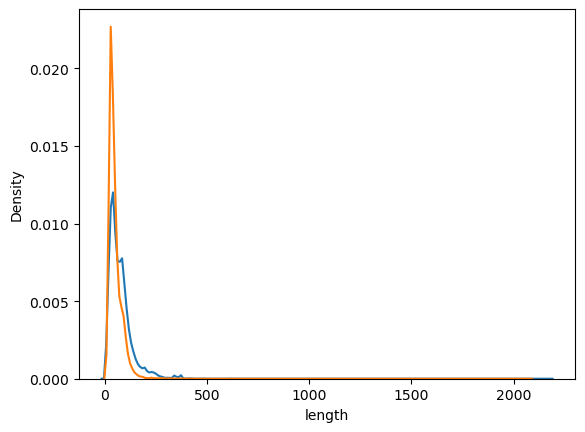

In [14]:
sns.kdeplot(data = final_df.loc[malicious_idx,'length'])
sns.kdeplot(data = final_df.loc[benign_idx,'length'])

<Axes: xlabel='alphabet_ratio', ylabel='Density'>

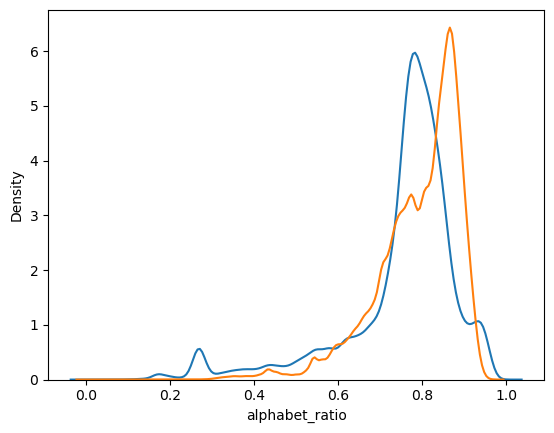

In [15]:
sns.kdeplot(data = final_df.loc[malicious_idx,'alphabet_ratio'])
sns.kdeplot(data = final_df.loc[benign_idx,'alphabet_ratio'])

<Axes: xlabel='digit_ratio', ylabel='Density'>

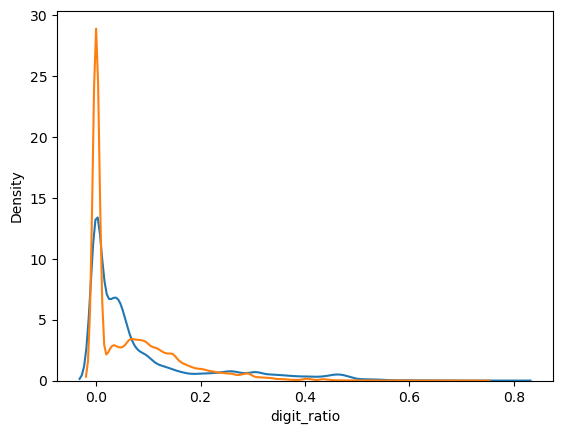

In [16]:
sns.kdeplot(data = final_df.loc[malicious_idx,'digit_ratio'])
sns.kdeplot(data = final_df.loc[benign_idx,'digit_ratio'])

<Axes: xlabel='non_alphanumeric_ratio', ylabel='Density'>

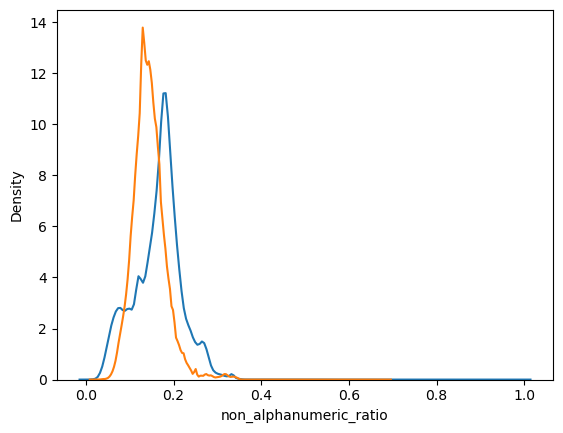

In [17]:
sns.kdeplot(data = final_df.loc[malicious_idx,'non_alphanumeric_ratio'])
sns.kdeplot(data = final_df.loc[benign_idx,'non_alphanumeric_ratio'])

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pcs = pca.fit_transform(X = final_df.drop(columns=['http','https','html','php']))
pcs

array([[-4.38037522e+01,  9.10955535e-01],
       [-2.47742234e+01,  3.13976134e-01],
       [-2.87587383e+01,  4.14636736e-01],
       ...,
       [-1.77472022e+01,  8.06701831e-02],
       [-1.47674467e+01, -1.06132305e-02],
       [-1.87661559e+01,  1.41856478e-01]])

In [19]:
pca_df = pd.DataFrame(data = pcs, columns=['PC1','PC2'])
pca_df['label'] = final_df['type'].values
pca_df.head()

,PC1,PC2,label
0,-43.803752,0.910956,1
1,-24.774223,0.313976,0
2,-28.758738,0.414637,0
3,28.233214,-1.281526,1
4,175.105211,-5.191651,1


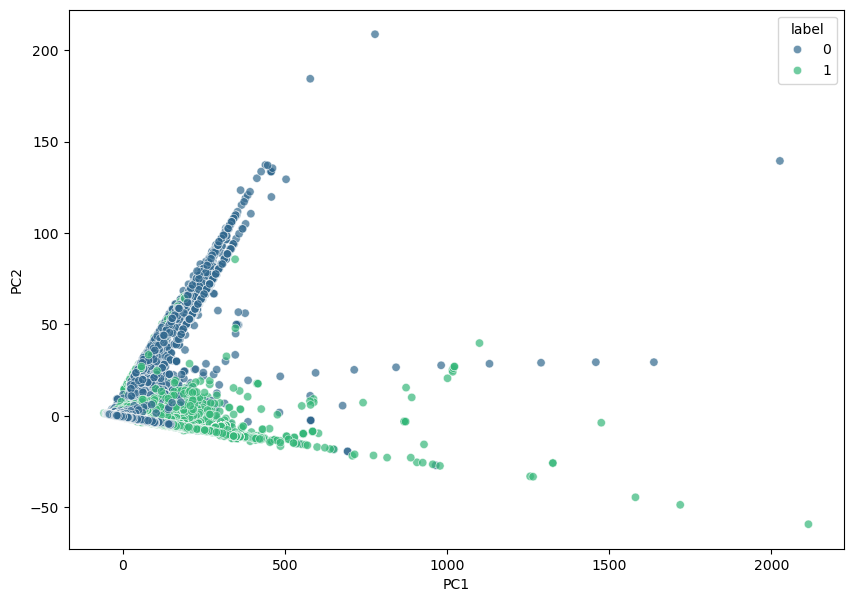

In [20]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='label',
    palette='viridis', 
    data=pca_df,
    alpha=0.7 
)
plt.show()

In [21]:
final_df.describe()

,length,alphabet_ratio,digit_ratio,non_alphanumeric_ratio,dot_count,underscore_count,slash_count,q_mark_count,percentage_count,http,https,html,php
count,641119.00000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000
mean,59.76247,0.777416,0.071993,0.151607,2.193950,0.425157,2.921902,0.221391,0.398489,0.255843,0.025549,0.183412,0.132723
std,44.89459,0.116655,0.100345,0.045204,1.491449,1.178802,1.895781,0.440003,4.166377,0.436335,0.157786,0.387004,0.339275
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.00000,0.735294,0.000000,0.123077,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,47.00000,0.800000,0.032258,0.148148,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,76.00000,0.857143,0.106667,0.176471,3.000000,0.000000,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,2175.00000,1.000000,0.800000,1.000000,42.000000,79.000000,41.000000,20.000000,231.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
final_df = final_df.reset_index(drop=True)
final_df['type'] = final_df['type'].astype(int)
final_df.head()

,length,alphabet_ratio,digit_ratio,non_alphanumeric_ratio,dot_count,underscore_count,slash_count,q_mark_count,percentage_count,http,https,html,php,type
0,16,0.812500,0.000000,0.187500,2,0,0,0,0,0,0,0,0,1
1,35,0.828571,0.028571,0.142857,2,1,2,0,0,0,0,1,0,0
2,31,0.806452,0.032258,0.161290,2,0,3,0,0,0,0,0,0,0
3,88,0.715909,0.079545,0.204545,3,2,3,1,0,1,0,0,1,1
4,235,0.846809,0.093617,0.059574,2,1,3,1,0,1,0,0,1,1


In [23]:
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()


In [24]:
exp.setup(data = final_df, target = 'type', numeric_features=['length','alphabet_ratio','digit_ratio','non_alphanumeric_ratio',
                                                       'dot_count','underscore_count','slash_count','q_mark_count','percentage_count'],
                                                       transformation= True, normalize= True, normalize_method= 'zscore', train_size = 0.75, 
                                                       data_split_stratify = True, fold_strategy = 'stratifiedkfold', fold = 5, session_id= 123
                                                       )

,Description,Value
0,Session id,123
1,Target,type
2,Target type,Binary
3,Original data shape,"(641119, 14)"
4,Transformed data shape,"(641119, 14)"
5,Transformed train set shape,"(480839, 14)"
6,Transformed test set shape,"(160280, 14)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


In [25]:
# exp.compare_models()


In [26]:
# extra_tree = exp.create_model('et')

In [27]:
# exp.plot_model(extra_tree, plot = 'confusion_matrix')

In [28]:
# exp.plot_model(extra_tree, plot = 'feature')

In [29]:
# exp.plot_model(extra_tree, plot = 'auc')

In [30]:
# exp.evaluate_model(extra_tree)


In [31]:
# tuned_extra_tree = exp.tune_model(extra_tree)

In [32]:
#exp.save_model(tuned_extra_tree, 'extra_tree_01')
#exp.save_experiment('exp_01')

In [33]:
tuned_extra_tree = exp.load_model('extra_tree_01')

Transformation Pipeline and Model Successfully Loaded


In [ ]:
url = '://www.youtube.com/watch?v=blxoBDKsN_o'

df = pd.DataFrame([{'url':url}])

In [72]:
df = feature_extraction(df,'url')

In [73]:
df = df.drop(columns = ['url'])
df

,length,alphabet_ratio,digit_ratio,non_alphanumeric_ratio,dot_count,underscore_count,slash_count,q_mark_count,percentage_count,http,https,html,php
0,46,0.804348,0.0,0.195652,2,1,3,1,0,1,0,0,0


In [74]:
tuned_extra_tree.predict(df)

array([1], dtype=int8)

In [34]:
#final_extra_tree_model = exp.finalize_model(tuned_extra_tree)

In [ ]:
#exp.save_model(final_extra_tree_model, 'final_extra_tree_model')

NameError: name 'final_extra_tree_model' is not defined